### Matching month-to-month CPS observations

February 15, 2019

Brian Dew, @bd_econ

-----

To Do:

- Correct 1996-97 data
- Add comments
- Clean up plot

In [1]:
import pandas as pd
import os

os.chdir('/home/brian/Documents/CPS/data/clean')

In [2]:
date_list = [(date_val.year, date_val.month) for date_val in 
             pd.date_range(start='1998-01-01', end='2018-12-01', freq='MS')]

date_pairs = list(zip(date_list, date_list[1:]))

start_year = date_pairs[0][0][0]

keep_cols = ['CPSID', 'PULINENO', 'AGE', 'FEMALE', 'WBHAO', 'PWLGWGT',
             'YEAR', 'MONTH', 'LFS']

def read_year(year):
    df = (pd.read_feather(f'cps{year}.ft', columns=keep_cols)
            .query('PWLGWGT > 0 and CPSID > 0'))
    return df

In [3]:
results = pd.Series()

df1 = read_year(start_year)
df2 = df1

for (year1, month1), (year2, month2) in date_pairs:
    if month2 == 1:
        df2 = read_year(year2)
    if month1 == 1 and year1 > start_year:
        df1 = df2
        
    d1 = df1.loc[df1['MONTH'] == month1]
    d2 = df2.loc[(df2['MONTH'] == month2) & 
                 (df2['LFS'] == 'Employed')]
    
    m = pd.merge(d1, d2, on=['CPSID', 'PULINENO'], how='inner')
    m = m[(m['WBHAO_x'] == m['WBHAO_y']) &
          (m['FEMALE_x'] == m['FEMALE_y']) &
          (m['AGE_y'] >= m['AGE_x']) &
          (m['AGE_x'] <= m['AGE_y'] + 1)]
    
    emp = m.loc[m['LFS_x'] != 'Employed', 'PWLGWGT_y'].sum()
    nilf = m.loc[m['LFS_x'] == 'NILF', 'PWLGWGT_y'].sum()
    
    date = pd.to_datetime(f'{year1}-{month1}-01')
    results[date] = (nilf/ emp) * 100

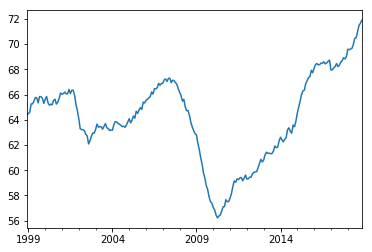

In [4]:
%matplotlib inline
results.rolling(12).mean().dropna().plot();